In [ ]:
# !pip install --upgrade transformers
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data_path = "/content/drive/MyDrive/sample_emails_clean.csv"
emails_clean = pd.read_csv(data_path)
pd.set_option('display.max_colwidth', None)

### Step 1: Sentence Tokenize

### Step 2: Label a Small Subset Manually

In [ ]:
import re

greeting_pattern = re.compile(
    r"^(dear|hi|hello|hey|greetings|good (morning|afternoon|evening))\b.*?[.,:\n]?",
    re.IGNORECASE
)


def label_greetings(df):
    labeled = []
    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)
        group["label"] = "O"
        for i in range(min(2, len(group))):
            sentence = group.loc[i, "sentence"]
            if isinstance(sentence, str) and greeting_pattern.search(sentence.strip()):
                group.loc[i, "label"] = "GREETING"
        labeled.append(group)
    return pd.concat(labeled, ignore_index=True)

labeled_sentences = label_greetings(emails_sentences)

In [ ]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")
closing_pattern = re.compile(
    r"(?i)\b("
    r"thank\s+you|thanks|thanks\s+again|thanks\s+and\s+regards|"
    r"sincerely|regards|best\s+regards|kind\s+regards|"
    r"warm\s+regards|many\s+thanks|cheers|happy\s+holidays|"
    r"CONFIDENTIALITY AND WARNING NOTICE:"
    r")\b[.,]?$"
)

def label_closing_and_signature(df):
    labeled = []

    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)
        if len(group) < 2:
            labeled.append(group)
            continue

        last_idxs = group.tail(2).index

        for i in last_idxs:
            if group.loc[i, "label"] != "O":
                continue

            sentence = group.loc[i, "sentence"]
            doc = nlp(sentence)

            has_person_or_org = any(ent.label_ in ("PERSON", "ORG") for ent in doc.ents)
            has_closing_phrase = closing_pattern.search(sentence) is not None

            if has_closing_phrase:
                group.loc[i, "label"] = "CLOSING"
            elif has_person_or_org:
                group.loc[i, "label"] = "SIGNATURE"

        labeled.append(group)

    return pd.concat(labeled, ignore_index=True)

labeled_sentences = label_closing_and_signature(labeled_sentences)


In [ ]:
def label_body(df):
    labeled = []

    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)
        group.loc[group["label"] == "O", "label"] = "BODY"
        labeled.append(group)

    return pd.concat(labeled, ignore_index=True)

labeled_sentences = label_body(labeled_sentences)


In [ ]:
label_counts = labeled_sentences['label'].value_counts()

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: BODY, Count: 4042
Label: SIGNATURE, Count: 389
Label: GREETING, Count: 30
Label: CLOSING, Count: 28


### Step 3: Train/Validation Split

### Step 4: Prepare for Model Training

### Step 5: Fine-Tune Transformer Model

### Step 6: Evaluate

## bert-base-cased

In [ ]:
import os
import re
import pandas as pd
import nltk
import spacy
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import EarlyStoppingCallback

nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('words')
nltk.download('punkt_tab')

def split_email(email_text):
    if not isinstance(email_text, str):
        email_text = str(email_text)
    return sent_tokenize(email_text)

def flatten_email_sentences(sample_emails):
    flattened = []
    for idx, row in sample_emails.iterrows():
        for sent in row["sentences"]:
            flattened.append({
                "email_id": idx,
                "sentence": sent,
                "label": ""
            })
    return pd.DataFrame(flattened)


greeting_pattern = re.compile(
    r"^(dear|hi|hello|hey|greetings|good (morning|afternoon|evening))\b.*?[.,:\n]?",
    re.IGNORECASE
)

def label_greetings(df):
    labeled = []
    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)
        group["label"] = "O"
        for i in range(min(2, len(group))):
            sentence = group.loc[i, "sentence"]
            if isinstance(sentence, str) and greeting_pattern.search(sentence.strip()):
                group.loc[i, "label"] = "GREETING"
        labeled.append(group)
    return pd.concat(labeled, ignore_index=True)


nlp = spacy.load("en_core_web_sm")
closing_pattern = re.compile(
    r"(?i)\b("
    r"thank\s+you|thanks|thanks\s+again|thanks\s+and\s+regards|"
    r"sincerely|regards|best\s+regards|kind\s+regards|"
    r"warm\s+regards|many\s+thanks|cheers|happy\s+holidays|"
    r"CONFIDENTIALITY AND WARNING NOTICE:"
    r")\b[.,]?$"
)

def label_closing_and_signature(df):
    labeled = []

    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)
        if len(group) < 2:
            labeled.append(group)
            continue

        last_idxs = group.tail(2).index

        for i in last_idxs:
            if group.loc[i, "label"] != "O":
                continue

            sentence = group.loc[i, "sentence"]
            doc = nlp(sentence)

            has_person_or_org = any(ent.label_ in ("PERSON", "ORG") for ent in doc.ents)
            has_closing_phrase = closing_pattern.search(sentence) is not None

            if has_closing_phrase:
                group.loc[i, "label"] = "CLOSING"
            elif has_person_or_org:
                group.loc[i, "label"] = "SIGNATURE"

        labeled.append(group)

    return pd.concat(labeled, ignore_index=True)


def label_body(df):
    labeled = []

    for email_id, group in df.groupby("email_id"):
        group = group.copy().reset_index(drop=True)

        group.loc[group["label"] == "O", "label"] = "BODY"

        labeled.append(group)

    return pd.concat(labeled, ignore_index=True)



def extend_labeled_dataset_with_signatures(
    existing_df: pd.DataFrame,
    signature_file_path: str,
    signature_column: str = "signature",
    save_path: str = None,
    shuffle: bool = True,
    random_state: int = 42
) -> pd.DataFrame:
    signature_df = pd.read_excel(signature_file_path)
    if signature_column not in signature_df.columns:
        raise ValueError(f"Column '{signature_column}' not found in the Excel file.")
    new_rows = pd.DataFrame({
        "email_id": ["synthetic_signature"] * len(signature_df),
        "sentence": signature_df[signature_column].astype(str).str.strip(),
        "label": ["SIGNATURE"] * len(signature_df)
    })
    extended_df = pd.concat([existing_df, new_rows], ignore_index=True)
    if shuffle:
        extended_df = extended_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    if save_path:
        extended_df.to_csv(save_path, index=False)
    return extended_df


# --- Configuration ---
MODEL_NAME = "bert-base-cased"
NUM_EPOCHS = 3
OUTPUT_DIR = "/content/drive/MyDrive/bert_structural_elements"
LOGGING_DIR = "./logs"
BATCH_SIZE = 8
WEIGHT_DECAY = 0.01
RANDOM_STATE = 42


def prepare_data(labeled_df):
    le = LabelEncoder()
    labeled_df = labeled_df.copy()
    labeled_df["label_id"] = le.fit_transform(labeled_df["label"])

    train_df, val_df = train_test_split(
        labeled_df[["sentence", "label_id"]],
        test_size=0.2,
        stratify=labeled_df["label_id"],
        random_state=RANDOM_STATE
    )
    return train_df, val_df, le

def tokenize_data(train_df, val_df):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    def tokenize(batch):
        return tokenizer(batch["sentence"], padding="max_length", truncation=True)

    train_dataset = train_dataset.map(tokenize, batched=True)
    val_dataset = val_dataset.map(tokenize, batched=True)
    if "label_id" in train_dataset.column_names:
        train_dataset = train_dataset.rename_column("label_id", "labels")
    if "label_id" in val_dataset.column_names:
        val_dataset = val_dataset.rename_column("label_id", "labels")
    return train_dataset, val_dataset, tokenizer


def train_model(train_dataset, val_dataset, tokenizer, num_labels, id2label, label2id, class_weights=None):
    print(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )


    if class_weights is not None:
        class_weights = class_weights.to(model.device)

        def compute_loss(model, inputs, return_outputs=False):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits, labels)
            return (loss, outputs) if return_outputs else loss

        model.compute_loss = compute_loss

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        logging_dir=LOGGING_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        weight_decay=WEIGHT_DECAY,
        logging_steps=50
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    return trainer


def evaluate_model(trainer, val_dataset, label_encoder):
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(axis=1)

    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot()
    plt.show()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
emails_clean["sentences"] = emails_clean["clean_main_message"].apply(split_email)
sample_emails = emails_clean.sample(n=500, random_state=42).reset_index(drop=True)
emails_sentences = flatten_email_sentences(sample_emails)
labeled_sentences = label_greetings(emails_sentences)
labeled_sentences = label_closing_and_signature(labeled_sentences)
labeled_sentences = label_body(labeled_sentences)
label_counts = labeled_sentences['label'].value_counts()

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: BODY, Count: 4042
Label: SIGNATURE, Count: 389
Label: GREETING, Count: 30
Label: CLOSING, Count: 28


In [ ]:
train_df, val_df, label_encoder = prepare_data(labeled_sentences)
train_dataset, val_dataset, tokenizer = tokenize_data(train_df, val_df)
id2label = {i: l for i, l in enumerate(label_encoder.classes_)}
label2id = {l: i for i, l in enumerate(label_encoder.classes_)}
print(id2label)
print(label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/3591 [00:00<?, ? examples/s]

Map:   0%|          | 0/898 [00:00<?, ? examples/s]

{0: 'BODY', 1: 'CLOSING', 2: 'GREETING', 3: 'SIGNATURE'}
{'BODY': 0, 'CLOSING': 1, 'GREETING': 2, 'SIGNATURE': 3}


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
OUTPUT_DIR = "./bert_structural_elements"
trainer_base = train_model(train_dataset, val_dataset, tokenizer, len(label_encoder.classes_), id2label, label2id)

bert-base-cased


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4-3301086958.py:215: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.252800,0.229124
2,0.200800,0.216001
3,0.093100,0.331483


              precision    recall  f1-score   support

        BODY       0.95      0.99      0.97       808
     CLOSING       0.83      0.83      0.83         6
    GREETING       0.75      1.00      0.86         6
   SIGNATURE       0.91      0.41      0.57        78

    accuracy                           0.94       898
   macro avg       0.86      0.81      0.81       898
weighted avg       0.94      0.94      0.93       898



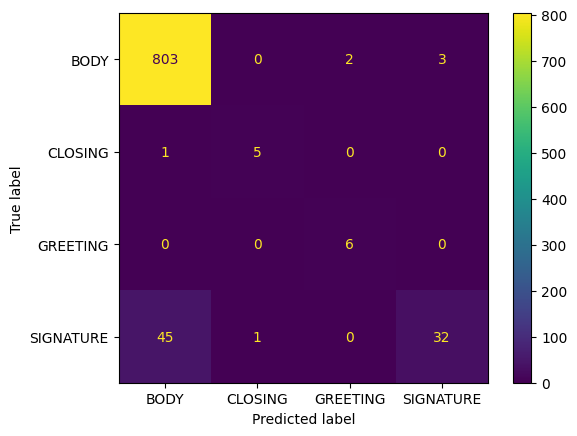

In [ ]:
evaluate_model(trainer_base, val_dataset, label_encoder)

### **Improvement:** Scaled Sample with Signatures


In [ ]:
# signature_list = pd.read_excel("/content/drive/MyDrive/sig_list.xlsx")
path = "/content/drive/MyDrive/signatures_list.xlsx"
labeled_sentences = pd.read_csv("/content/drive/MyDrive/scaled_labeled_sentences.csv")
final_labeled_sentences = extend_labeled_dataset_with_signatures(labeled_sentences, path)

In [ ]:
label_counts = final_labeled_sentences['label'].value_counts()
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: BODY, Count: 4042
Label: CLOSING, Count: 587
Label: SIGNATURE, Count: 521
Label: GREETING, Count: 301


In [ ]:
train_df, val_df, label_encoder = prepare_data(final_labeled_sentences)
train_dataset, val_dataset, tokenizer = tokenize_data(train_df, val_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/4360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['sentence', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4360
})

In [ ]:
id2label = {i: l for i, l in enumerate(label_encoder.classes_)}
label2id = {l: i for i, l in enumerate(label_encoder.classes_)}
print(id2label)
print(label2id)

{0: 'BODY', 1: 'CLOSING', 2: 'GREETING', 3: 'SIGNATURE'}
{'BODY': 0, 'CLOSING': 1, 'GREETING': 2, 'SIGNATURE': 3}


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
NUM_EPOCHS = 4
trainer = train_model(train_dataset, val_dataset, tokenizer, len(label_encoder.classes_), id2label, label2id)

bert-base-cased


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4-3301086958.py:215: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.142300,0.105153
2,0.127400,0.136038
3,0.040400,0.128700


              precision    recall  f1-score   support

        BODY       0.98      0.99      0.99       809
     CLOSING       0.90      0.92      0.91       118
    GREETING       0.98      0.98      0.98        60
   SIGNATURE       0.97      0.85      0.90       104

    accuracy                           0.97      1091
   macro avg       0.96      0.94      0.95      1091
weighted avg       0.97      0.97      0.97      1091



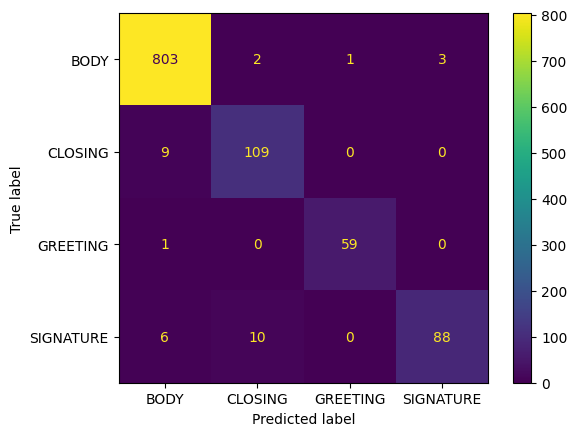

In [ ]:
evaluate_model(trainer, val_dataset, label_encoder)

### **DeBERTa** Model

In [ ]:
MODEL_NAME = "microsoft/deberta-v3-base"
train_df, val_df, label_encoder = prepare_data(final_labeled_sentences)
train_dataset, val_dataset, tokenizer = tokenize_data(train_df, val_df)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/4360 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['sentence', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4360
})

In [ ]:
MODEL_NAME = "microsoft/deberta-v3-base"
OUTPUT_DIR = "/content/drive/MyDrive/deberta_structural_elements"
id2label = {i: l for i, l in enumerate(label_encoder.classes_)}
label2id = {l: i for i, l in enumerate(label_encoder.classes_)}
# print(id2label)
# print(label2id)
os.environ["WANDB_DISABLED"] = "true"
trainer_deberta = train_model(train_dataset, val_dataset, tokenizer, len(label_encoder.classes_), id2label, label2id)

microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4-3301086958.py:215: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.220000,0.162307
2,0.146500,0.143063
3,0.076600,0.095758
4,0.056700,0.094322


              precision    recall  f1-score   support

        BODY       1.00      0.99      0.99       809
     CLOSING       0.92      0.97      0.95       118
    GREETING       0.98      1.00      0.99        60
   SIGNATURE       0.96      0.92      0.94       104

    accuracy                           0.98      1091
   macro avg       0.96      0.97      0.97      1091
weighted avg       0.98      0.98      0.98      1091



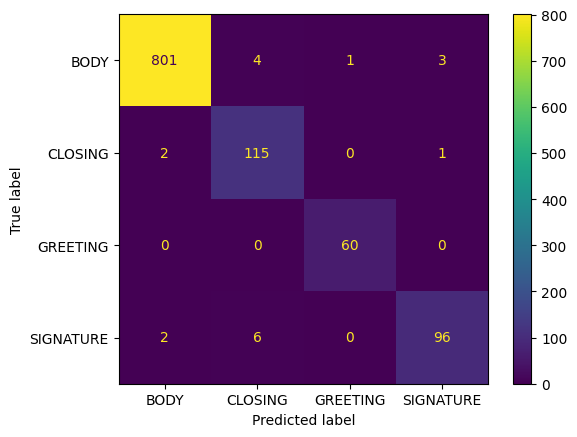

In [ ]:
evaluate_model(trainer_deberta , val_dataset, label_encoder)